## Modeling


This is a notebook to create a model that will answer the problem of assiging a genre to a song based on Spotify
metadata.  For this problem I have chosen to use a multiclass classification neural network with the backend being
writen in pytorch. This model will be able to beat our baseline score by a magnitude of 10.

#### Imports

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F


#### Read in clean data

In [208]:
data = pd.read_csv('../data/clean_data.csv')

data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5,mode_1
0,0.831,0.814,-7.364,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,2Vc6NJ9PW9gD9q343XFRKx,...,0,0,0,0,0,0,0,1,0,1
1,0.719,0.493,-7.230,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,7pgJBLVz5VmnL7uGHmRj6p,...,0,0,1,0,0,0,0,1,0,1
2,0.850,0.893,-4.783,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,0vSWgAlfpye0WCGeNmuNhy,...,0,0,0,0,0,0,0,1,0,1
3,0.476,0.781,-4.710,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,0VSXnJqQkwuH2ei1nOQ1nu,...,0,0,0,0,0,0,1,0,0,1
4,0.798,0.624,-7.668,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,4jCeguq9rMTlbMmPHuO7S3,...,0,0,0,0,0,0,0,1,0,1


In [209]:
data.info()

classes = data['genre'].unique()
num_classes = len(classes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   danceability          42305 non-null  float64
 1   energy                42305 non-null  float64
 2   loudness              42305 non-null  float64
 3   speechiness           42305 non-null  float64
 4   acousticness          42305 non-null  float64
 5   instrumentalness      42305 non-null  float64
 6   liveness              42305 non-null  float64
 7   valence               42305 non-null  float64
 8   tempo                 42305 non-null  float64
 9   id                    42305 non-null  object 
 10  duration_ms           42305 non-null  int64  
 11  genre                 42305 non-null  int64  
 12  song_name             42299 non-null  object 
 13  song_name_char_count  42305 non-null  int64  
 14  song_name_word_count  42305 non-null  int64  
 15  key_1              

#### Create Dataset for our features (`X`) and target values (`y`)

In [210]:
X = data.drop(columns=['id','genre', 'song_name'])
y = np.array(data['genre'])


#### Establish a Baseline Score

To establish a baseline accuracy score, I will choose a random number between 0 and 14.  If the number chosen matches
the value in the target column, then the prediction is correct, if not then it is wrong.  The average of the list of
values will determine the baseline accuracy.

In [232]:
#creates of lists where if the random number is the same then the if statement returns a one.

base_preds = [1 if (np.random.randint(14)) == value else 0 for value in data['genre']]
np.mean(base_preds)

0.06587873773785605

This means that the baseline accuracy is ~ 6.59%


#### Split data into training and testing datasets

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify= y)


#### Apply Standard Scaling

In [212]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


Standard scaling is needed to measure all values in comparison to one another. By using standard scaling all value
weights can be equally compared.


#### Create Tensor

In [265]:
X_train_t = torch.tensor(X_train_sc).float()
y_train_t = torch.tensor(y_train).long()

X_test_t = torch.tensor(X_test_sc).float()
y_test_t = torch.tensor(y_test).long()


Using pytorch the data sets need to be in tensor 1D arrays. These data sets will be in the correct format for the model.

> This line of code is to save the number of features, so I can use them in my first layer as the number of nodes.

In [214]:
nodes = X_train_t.shape[1]
nodes


27

#### Build Model
Using Pytorch I am building a function to create my model.  This model is set up with 4 hidden layers and a single input
and output layer. Through trial and error I came up with using different node amounts for each of the hidden layers.

In [266]:
class MultiClassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(nodes, 32)
        self.h2 = nn.Linear(32, 64)
        self.h3 = nn.Linear(64, 128)
        self.h4 = nn.Linear(128, 128)
        self.h5 = nn.Linear(128, 256)
        self.h6 = nn.Linear(256, 512)
        self.out = nn.Linear(512, 15)

    def forward(self, X):
        X = F.relu(self.h1(X))
        X = F.relu(self.h2(X))
        X = F.relu(self.h3(X))
        X = F.relu(self.h4(X))
        X = F.relu(self.h5(X))
        X = F.relu(self.h6(X))
        return self.out(X)


model = MultiClassModel()

loss_fn = nn.CrossEntropyLoss()

#### Create `torch.optim.Adam()` optimizer.

This creates an optimizer for the model. The optimizer alters the weights and reduces the losses of a neural network.
`Adam` is the latest optimizer to use in the field.  I chose the learning rate of 0.001 as that provided the best model,
after series fo tests.

In [267]:
optimizer = torch.optim.Adam(model.parameters(), lr=.01)


### Run The Model

This cell runs a loop that will go through every epoch training the model and recording the accuracy and loss as the
number of epochs increase. The number of Epochs was chosen as this is the quickest, and most accurate model that can be
created with becoming over fit.

In [268]:
train_loss = []
testing_loss = []
train_accuracy = []
test_accuracy = []
batch_size = 256
training_size = X.shape[0]
count = 0
epochs = 150
for epoch in range(epochs):
    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = loss_fn(test_pred,y_test_t)
        testing_loss.append(test_loss.item())
        train_pred = model(X_train_t)
        loss = loss_fn(train_pred, y_train_t)
        train_loss.append(loss.item())
        train_accuracy.append((train_pred.argmax(axis=1) == y_train_t).float().mean())
        test_accuracy.append((test_pred.argmax(axis=1) == y_test_t).float().mean())
    for batch_idx in range(0, training_size, batch_size):
        # zero out the optimizer's gradients
        optimizer.zero_grad()

        # Create X_batch and y_batch
        X_batch = X_train_t[batch_idx:batch_idx + batch_size]
        y_batch = y_train_t[batch_idx:batch_idx + batch_size]

        # get predictions and loss
        pred = model(X_batch)

        loss = loss_fn(pred, y_batch)
        # back propagate
        loss.backward()

        # step
        optimizer.step()
    count += 1
    if count % (epochs//10) == 0:
        print(f'Model is {(count/epochs) * 100}% done.')

Model is 10.0% done.
Model is 20.0% done.
Model is 30.0% done.
Model is 40.0% done.
Model is 50.0% done.
Model is 60.0% done.
Model is 70.0% done.
Model is 80.0% done.
Model is 90.0% done.
Model is 100.0% done.


How did the model do?

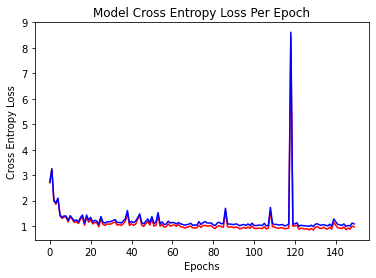

In [269]:
plt.plot(train_loss, color='red')
plt.plot(testing_loss, color= 'blue')
plt.title('Model Cross Entropy Loss Per Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')

plt.savefig('../imgs/loss_plt_150.png', dpi= 400, bbox_inches= 'tight')

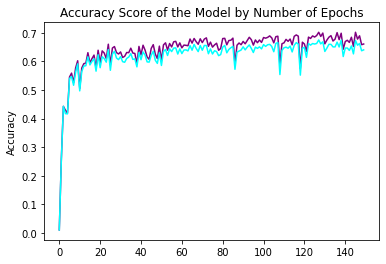

In [270]:
plt.plot(train_accuracy, color= 'purple')
plt.plot(test_accuracy, color= 'cyan')
plt.title('Accuracy Score of the Model by Number of Epochs')
plt.ylabel('Accuracy')
plt.savefig('../imgs/accuracy_model_before_reg_150.png', dpi= 400, bbox_inches= 'tight')

In [271]:
max(test_accuracy)

tensor(0.6750)


### Implement Dropout Regularization

In this section I will build a new Neural Network with dropout regularization.  Instead of creating a function to build
the model. I will build a model similar to how i would build a model in Keras, where I create each layer is sequential
order.

In [254]:
#instantiate Model
model_drop = torch.nn.Sequential()
#input layer
#first module with the number of nodes as the number of features, 27
#also this module will output 500 different nodes.
model_drop.add_module("dropout1", torch.nn.Dropout(p=0.2))
model_drop.add_module("dense1", torch.nn.Linear(nodes,1024))
model_drop.add_module("relu1", torch.nn.ReLU())
model_drop.add_module("dropout2", torch.nn.Dropout(p=0.3))
#1st hidden layer
model_drop.add_module("dense2", torch.nn.Linear(1024,512))
model_drop.add_module("relu2", torch.nn.ReLU())
model_drop.add_module("dropout3", torch.nn.Dropout(p=0.3))
#2nd hidden layer
model_drop.add_module("dense3", torch.nn.Linear(512,256))
model_drop.add_module("relu3", torch.nn.ReLU())
model_drop.add_module("dropout4", torch.nn.Dropout(p=0.4))
#3rd hidden layer
model_drop.add_module("dense4", torch.nn.Linear(256,128))
model_drop.add_module("relu4", torch.nn.ReLU())
model_drop.add_module("dropout5", torch.nn.Dropout(p=0.3))
#4th hidden layer
model_drop.add_module("dense5", torch.nn.Linear(128,64))
model_drop.add_module("relu5", torch.nn.ReLU())
model_drop.add_module("dropout6", torch.nn.Dropout(p=0.4))
#output layer
model_drop.add_module("dense6", torch.nn.Linear(64,num_classes))


This model has the same number of hidden layers as before with a slightly different number of nodes between layers. This
was done to assist in the dropout that happens during this model compared to the one created earlier.  The reason to
utilize dropout regularization is to prevent the eradic jumps seen in the previous model. This creates a more stable and
reliable model.

#### Create Loss Function

In [ ]:
drop_loss = torch.nn.CrossEntropyLoss()

This is the function to determine the loss of the model.  For a multiclass model, the correct loss function is cross
entropy loss.

In [255]:
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=.001)

In [256]:
train_loss_d = []
testing_loss_d = []
train_accuracy_d = []
test_accuracy_d = []
batch_size = 4096
training_size = X.shape[0]
count = 0
epochs = 500
for epoch in range(epochs):
    with torch.no_grad():
        test_pred = model_drop(X_test_t)
        test_loss = drop_loss(test_pred,y_test_t)
        testing_loss_d.append(test_loss.item())
        train_pred = model_drop(X_train_t)
        loss = drop_loss(train_pred, y_train_t)
        train_loss_d.append(loss.item())
        train_accuracy_d.append((train_pred.argmax(axis=1) == y_train_t).float().mean())
        test_accuracy_d.append((test_pred.argmax(axis=1) == y_test_t).float().mean())
    for batch_idx in range(0, training_size, batch_size):
        # zero out the optimizer's gradients
        optimizer_drop.zero_grad()

        # Create X_batch and y_batch
        X_batch = X_train_t[batch_idx:batch_idx + batch_size]
        y_batch = y_train_t[batch_idx:batch_idx + batch_size]

        # get predictions and loss
        pred = model_drop(X_batch)

        loss = drop_loss(pred, y_batch)
        # back propagate
        loss.backward()

        # step
        optimizer_drop.step()
    count += 1
    if count % (epochs//20) == 0:
        print(f'Model is {(count/epochs) * 100}% done.')

Model is 5.0% done.
Model is 10.0% done.
Model is 15.0% done.
Model is 20.0% done.
Model is 25.0% done.
Model is 30.0% done.
Model is 35.0% done.
Model is 40.0% done.
Model is 45.0% done.
Model is 50.0% done.
Model is 55.00000000000001% done.
Model is 60.0% done.
Model is 65.0% done.
Model is 70.0% done.
Model is 75.0% done.
Model is 80.0% done.
Model is 85.0% done.
Model is 90.0% done.
Model is 95.0% done.
Model is 100.0% done.


How did the model do?

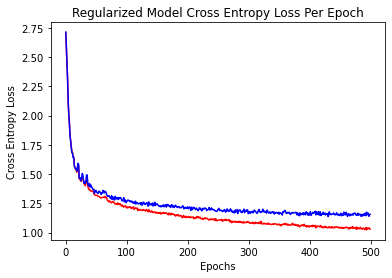

In [257]:
plt.plot(train_loss_d, color='red')
plt.plot(testing_loss_d, color= 'blue')
plt.title('Regularized Model Cross Entropy Loss Per Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')

plt.savefig('../imgs/reg_loss_plt_6.png', dpi= 400, bbox_inches= 'tight')

This plot shows how the loss decreased as the number of epochs increased.  One key thing to note is the overfitting
starting around epoch 100.

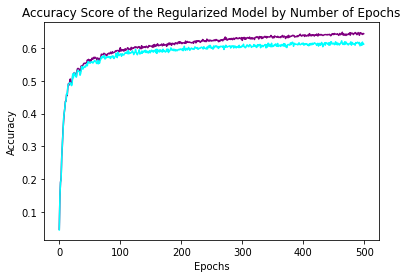

In [258]:
plt.plot(train_accuracy_d, color= 'purple')
plt.plot(test_accuracy_d, color= 'cyan')
plt.title('Accuracy Score of the Regularized Model by Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('../imgs/accuracy_model_after_reg_6.png', dpi= 400, bbox_inches= 'tight')

This plot shows how the accuracy of the model changed as the number of epochs grew. This shows that the model was
starting to become over fit as the training line (purple) diverges from the test line (cyan).

## Conclusions and Recommendations
* I created a neural network model to predict the genre of a song given attribute data about the song.


* This model without regularization is over ten fold better than the baseline model.


* Utilizing Dropout Regularization did not improve the model in terms of accuracy, due to the data deficiency. It did improve the model by making the model less over fit and far less erratic. However, regardless of the model set up, I have never been able to achieve an accuracy score above 70%



